In [1]:
import os
import sys
import inspect

# Insert modules directory, TODO create setup.py file
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
reports_dir = os.path.dirname(currentdir)
project_home_dir = os.path.dirname(reports_dir)
sys.path.insert(0, f"{project_home_dir}/qcnn")

In [2]:
import numpy as np
import pandas as pd
from pprint import pprint
from reporting_functions import (
    get_file_content,
    get_result_table,
    get_result_table_target_pairs,
)
from joblib import dump, load
from collections import namedtuple
from circuit_presets import get_wire_combos

In [32]:
experiments_path = f"{project_home_dir}/experiments"
experiment_filename = "experiment.json"
target_levels = [
    "classical",
    "country",
    "rock",
    "pop",
    "hiphop",
    "jazz",
    "blues",
    "disco",
    "metal",
    "reggae",
]

In [33]:
experiment_id = 124
experiment_config = get_file_content(
    f"{experiments_path}/{experiment_id}/{experiment_filename}"
)

In [34]:
pprint(experiment_config)

{'ID': 124,
 'data': {'path': '/home/matt/dev/projects/quantum-cnn/data/archive/Data/features_30_sec.csv',
          'sampling': {'random_state': 42, 'test_size': 0.3},
          'target_column': 'label',
          'target_pairs': [['classical', 'country'],
                           ['classical', 'rock'],
                           ['classical', 'pop'],
                           ['classical', 'hiphop'],
                           ['classical', 'jazz'],
                           ['classical', 'blues'],
                           ['classical', 'disco'],
                           ['classical', 'metal'],
                           ['classical', 'reggae'],
                           ['country', 'rock'],
                           ['country', 'pop'],
                           ['country', 'hiphop'],
                           ['country', 'jazz'],
                           ['country', 'blues'],
                           ['country', 'disco'],
                           ['country', 'metal

In [35]:
path = f"{experiment_config.get('path')}/{experiment_config.get('ID')}"

In [36]:
y_test = pd.read_csv(f"{path}/y_test.csv", index_col=0)
X_test = pd.read_csv(f"{path}/X_test.csv", index_col=0)

In [37]:
model_names = [
    filename.split("-model_configuration.joblib")[0]
    for filename in os.listdir(path)
    if "-model_configuration.joblib" in filename
]

In [38]:
# Gather results
Results = namedtuple(
    "Results", ["model_name", "y_test_hat", "clf", "model_configuration", "samples_tfd", "pipeline"]
)
result_list = []
for model_name in model_names:
    y_test_hat = pd.read_csv(f"{path}/{model_name}-yhat.csv", index_col=0)
    clf = load(f"{path}/{model_name}-clf_results.joblib")
    model_configuration = load(f"{path}/{model_name}-model_configuration.joblib")
    samples_tfd = load(f"{path}/{model_name}-samples_tfd.joblib")
    pipeline = load(f"{path}/{model_name}-pipeline.joblib")
    result_list = result_list + [
        Results(
            model_name,
            y_test_hat=y_test_hat,
            clf=clf,
            model_configuration=model_configuration,
            samples_tfd=samples_tfd,
            pipeline=pipeline,
        )
    ]
print(len(result_list))

45


In [39]:
# Table
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

result_data = pd.DataFrame(
    {
        "model_name": [],
        "model_type": [],
        "algorithm": [],
        "classification_type": [],
        "embedding_type": [],
        "scaler_method": [],
        "scaler_param_str": [],
        "selection_method": [],
        "selection_param_str": [],
        "target_pair": [],
        "additional_structure": [],
        "additional_structure_str": [],
        "circuit":[],
        "target_pair_str": [],
        "top_features" : [],
        "mean_test_score": [],
        "std_test_score": [],
        "params": [],
        "accuracy": [],
        "precision": [],
        "recall": [],
        "f1": [],
        "loss_train_history": [],
    }
)
for result in result_list:
    y_test_hat = result.y_test_hat
    clf = result.clf
    model_configuration = result.model_configuration
    samples_tfd = result.samples_tfd
    model_name = result.model_name

    precision, recall, fscore, support = precision_recall_fscore_support(
        samples_tfd.y_test, y_test_hat, average="binary"  # TODO multiclass
    )
    accuracy = accuracy_score(samples_tfd.y_test, y_test_hat)
    tmp_result = model_configuration._asdict()
    tmp_result["model_name"] = model_name

    tmp_result["target_pair_str"] = "_".join(model_configuration.target_pair)
    tmp_result["additional_structure_str"] = f"{model_configuration.additional_structure[0]}_{model_configuration.additional_structure[1]}_{model_configuration.additional_structure[2]}"
    tmp_result["circuit"] = model_configuration.additional_structure[0]
    tmp_result["mean_test_score"] = clf.cv_results_["mean_test_score"][clf.best_index_]
    tmp_result["std_test_score"] = clf.cv_results_["std_test_score"][clf.best_index_]
    tmp_result["params"] = clf.cv_results_["params"][clf.best_index_]
    
    if result.model_configuration.selection_method == "tree":
        tmp_result["top_features"] = X_test.columns[result.pipeline.named_steps.get("tree")._get_support_mask()]
    else:
        tmp_result["top_features"] = None
        

    tmp_result["accuracy"] = accuracy
    tmp_result["precision"] = precision
    tmp_result["recall"] = recall
    tmp_result["f1"] = fscore
    tmp_result["loss_train_history"] = None  # set for quantum
    result_data = result_data.append(tmp_result, ignore_index=True)

In [40]:
result_data.fillna("None", inplace=True)
result_data.head()

,model_name,model_type,algorithm,classification_type,embedding_type,scaler_method,scaler_param_str,selection_method,selection_param_str,target_pair,...,target_pair_str,top_features,mean_test_score,std_test_score,params,accuracy,precision,recall,f1,loss_train_history
0,quantum-qcnn-binary-Angle-minmax-max_features=...,quantum,qcnn,binary,Angle,minmax,max_features=8_n_estimators=50,tree,"feature_range=[0, 1.5707963267948966]","[rock, blues]",...,rock_blues,"Index(['mfcc6_mean', 'perceptr_var', 'mfcc4_me...",-14.645067,0.401826,{'n_iter': 100},0.700000,0.694444,0.714286,0.704225,None
1,quantum-qcnn-binary-Angle-minmax-max_features=...,quantum,qcnn,binary,Angle,minmax,max_features=8_n_estimators=50,tree,"feature_range=[0, 1.5707963267948966]","[country, blues]",...,country_blues,"Index(['mfcc6_mean', 'mfcc4_mean', 'spectral_b...",-15.287864,0.476323,{'n_iter': 100},0.694444,0.618182,0.971429,0.755556,None
2,quantum-qcnn-binary-Angle-minmax-max_features=...,quantum,qcnn,binary,Angle,minmax,max_features=8_n_estimators=50,tree,"feature_range=[0, 1.5707963267948966]","[hiphop, blues]",...,hiphop_blues,"Index(['spectral_centroid_var', 'rolloff_mean'...",-12.592468,0.379138,{'n_iter': 100},0.762712,1.000000,0.600000,0.750000,None
3,quantum-qcnn-binary-Angle-minmax-max_features=...,quantum,qcnn,binary,Angle,minmax,max_features=8_n_estimators=50,tree,"feature_range=[0, 1.5707963267948966]","[jazz, metal]",...,jazz_metal,"Index(['mfcc6_mean', 'mfcc10_mean', 'mfcc17_me...",-9.000040,0.611839,{'n_iter': 100},0.968254,0.966667,0.966667,0.966667,None
4,quantum-qcnn-binary-Angle-minmax-max_features=...,quantum,qcnn,binary,Angle,minmax,max_features=8_n_estimators=50,tree,"feature_range=[0, 1.5707963267948966]","[country, reggae]",...,country_reggae,"Index(['mfcc3_var', 'rolloff_var', 'spectral_b...",-15.069536,1.038646,{'n_iter': 100},0.681818,0.605263,0.793103,0.686567,None


In [21]:
experiment_config["model"]["quantum"]["qcnn"].get("wire_pattern_list")

[[8, 1, 'outside']]

In [54]:
wire_combo = [8, 1, 'outside']
print(wire_combo)
get_wire_combos(wire_combo[0], wire_combo[1], wire_combo[2])

[8, 1, 'outside']


{'c_1': [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 0)],
 'p_1': [(0, 1), (1, 2), (6, 7), (7, 0)],
 'c_2': [(3, 4), (4, 5), (5, 6), (6, 3)],
 'p_2': [(3, 4), (6, 3)],
 'c_3': [(5, 6)],
 'p_3': [(5, 6)]}

In [48]:
tmp_result = [result for result in result_list]
#tmp_result

In [53]:
tmp_result[0].model_name

"quantum-qcnn-binary-Angle-minmax-max_features=8_n_estimators=50-tree-feature_range=[0, 1.5707963267948966]-['rock', 'blues']-('U_5', 'psatz1', [8, 1, 'outside'])"

#### Result pairs

tree - ('U_5', 'psatz1', [8, 1, 'outside'])

In [41]:
get_result_table_target_pairs(result_data, "algorithm", "target_pair_str", "accuracy")

,pop,jazz,metal,classical,blues,reggae,rock,disco,hiphop,country,Average
pop,NaN,0.928571,1.0,0.930233,0.844828,0.884615,0.827586,0.596491,0.765957,0.85,0.847587
jazz,0.928571,NaN,0.968254,0.433962,0.75,0.870968,0.75,0.940299,0.982456,0.628571,0.805898
metal,1.0,0.968254,NaN,0.96,0.861538,0.864407,0.784615,0.8125,0.888889,0.791045,0.881250
classical,0.930233,0.433962,0.96,NaN,0.836364,0.612245,0.854545,1.0,0.977273,0.929825,0.837161
blues,0.844828,0.75,0.861538,0.836364,NaN,0.703125,0.7,0.797101,0.762712,0.694444,0.772235
reggae,0.884615,0.870968,0.864407,0.612245,0.703125,NaN,0.609375,0.746032,0.773585,0.681818,0.749574
rock,0.827586,0.75,0.784615,0.854545,0.7,0.609375,NaN,0.652174,0.830508,0.666667,0.741719
disco,0.596491,0.940299,0.8125,1.0,0.797101,0.746032,0.652174,NaN,0.534483,0.84507,0.769350
hiphop,0.765957,0.982456,0.888889,0.977273,0.762712,0.773585,0.830508,0.534483,NaN,0.819672,0.815059
country,0.85,0.628571,0.791045,0.929825,0.694444,0.681818,0.666667,0.84507,0.819672,NaN,0.767457


In [25]:
pd.set_option('display.max_rows', 100)
get_result_table(
    result_data,
    ["algorithm", "additional_structure_str", "selection_method", "circuit", "target_pair_str"],
    "accuracy",
)


target_pair_str,blues_disco,blues_metal,blues_reggae,classical_blues,classical_country,classical_disco,classical_hiphop,classical_jazz,classical_metal,classical_pop,...,pop_metal,pop_reggae,rock_blues,rock_disco,rock_hiphop,rock_jazz,rock_metal,rock_pop,rock_reggae,algorithm Average
"(qcnn, U_5_psatz1_[8, 1, 'outside'], tree, U_5)",0.797101,0.861538,0.703125,0.836364,0.929825,1.0,0.977273,0.433962,0.96,0.930233,...,1.0,0.884615,0.7,0.652174,0.830508,0.75,0.784615,0.827586,0.609375,0.798729
additional_structure_str Average,0.797101,0.861538,0.703125,0.836364,0.929825,1.0,0.977273,0.433962,0.96,0.930233,...,1.0,0.884615,0.7,0.652174,0.830508,0.75,0.784615,0.827586,0.609375,0.798729


In [55]:
get_result_table_target_pairs(result_data, "algorithm", "target_pair_str", "std_test_score")

,pop,jazz,metal,classical,blues,reggae,rock,disco,hiphop,country,Average
pop,NaN,2.062153,0.79529,1.599617,1.180572,3.173174,1.478551,0.922061,1.330519,2.142829,1.631641
jazz,2.062153,NaN,0.611839,2.165345,0.635937,1.267968,0.978659,1.880891,1.200132,0.99869,1.311290
metal,0.79529,0.611839,NaN,0.582794,0.807651,0.840208,0.423232,1.251931,0.949458,0.277617,0.726669
classical,1.599617,2.165345,0.582794,NaN,2.649674,1.275705,0.79474,1.275866,0.470588,1.131481,1.327312
blues,1.180572,0.635937,0.807651,2.649674,NaN,1.270314,0.401826,1.67608,0.379138,0.476323,1.053057
reggae,3.173174,1.267968,0.840208,1.275705,1.270314,NaN,2.14445,0.976069,1.945732,1.038646,1.548030
rock,1.478551,0.978659,0.423232,0.79474,0.401826,2.14445,NaN,0.896874,0.84304,1.066836,1.003134
disco,0.922061,1.880891,1.251931,1.275866,1.67608,0.976069,0.896874,NaN,1.032647,1.319811,1.248026
hiphop,1.330519,1.200132,0.949458,0.470588,0.379138,1.945732,0.84304,1.032647,NaN,1.864254,1.112834
country,2.142829,0.99869,0.277617,1.131481,0.476323,1.038646,1.066836,1.319811,1.864254,NaN,1.146276


In [27]:
get_result_table(
    result_data,
    ["algorithm", "additional_structure_str", "selection_method", "circuit", "target_pair_str"],
    "std_test_score",
)

target_pair_str,blues_disco,blues_metal,blues_reggae,classical_blues,classical_country,classical_disco,classical_hiphop,classical_jazz,classical_metal,classical_pop,...,pop_metal,pop_reggae,rock_blues,rock_disco,rock_hiphop,rock_jazz,rock_metal,rock_pop,rock_reggae,algorithm Average
"(qcnn, U_5_psatz1_[8, 1, 'outside'], tree, U_5)",1.67608,0.807651,1.270314,2.649674,1.131481,1.275866,0.470588,2.165345,0.582794,1.599617,...,0.79529,3.173174,0.401826,0.896874,0.84304,0.978659,0.423232,1.478551,2.14445,1.210827
additional_structure_str Average,1.67608,0.807651,1.270314,2.649674,1.131481,1.275866,0.470588,2.165345,0.582794,1.599617,...,0.79529,3.173174,0.401826,0.896874,0.84304,0.978659,0.423232,1.478551,2.14445,1.210827


In [28]:
target_pair = ["classical", "pop"]
# target_pair = ["pop", "disco"]
# target_pair = ["rock", "blues"]
#target_pair = ["rock", "reggae"]
filtered_results = [
    result
    for result in result_list
    if result.model_configuration.target_pair == target_pair
]
# filtered_results = [
#     result for result in result_list if genre in result.model_configuration.target_pair
# ]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

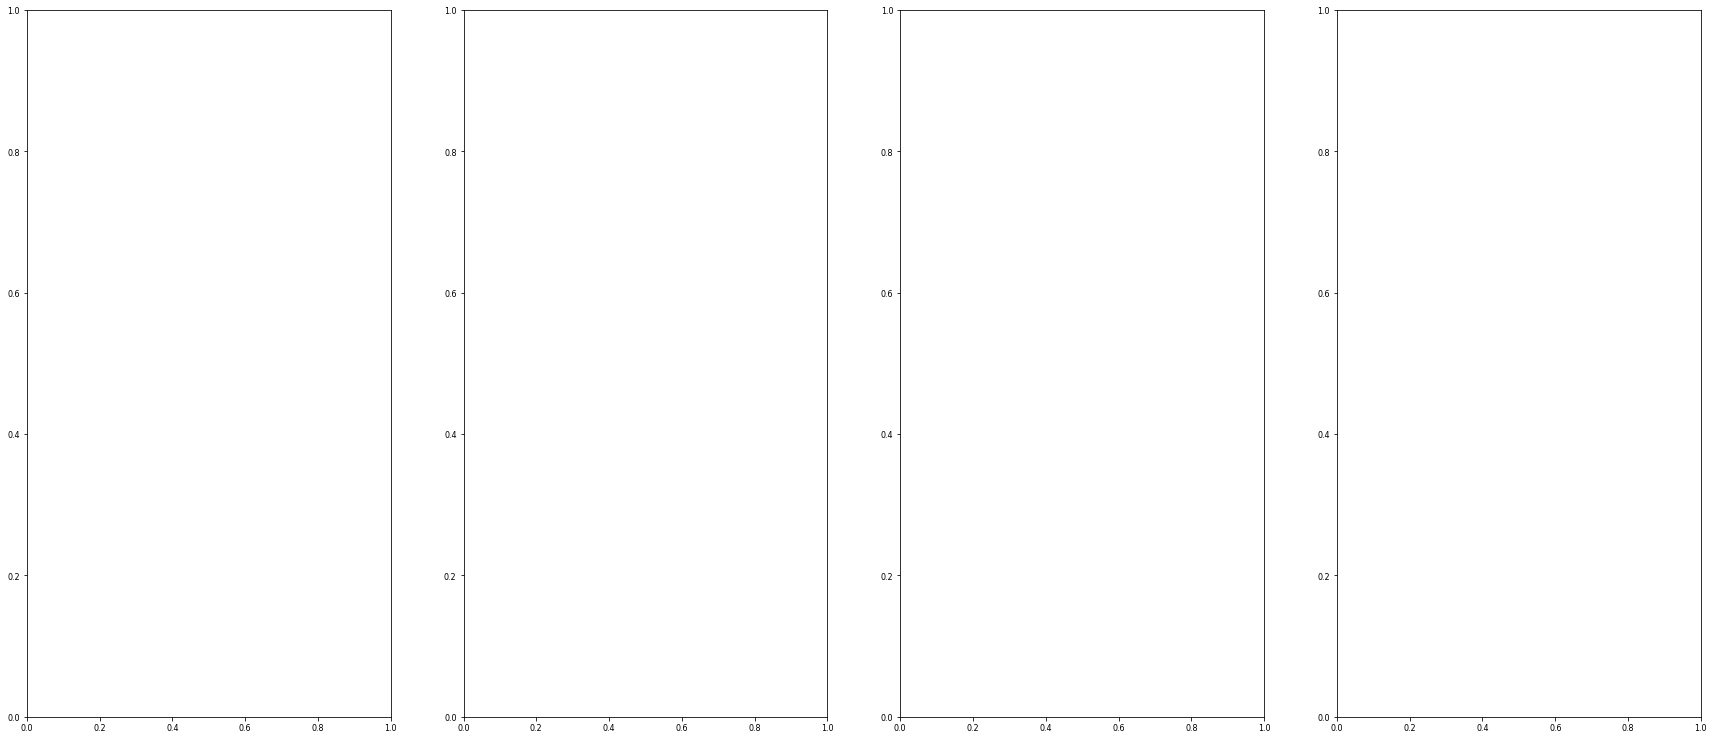

In [29]:
%matplotlib inline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

import matplotlib.pyplot as plt

# Customize matplotlib
SMALL_SIZE = 8
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc("font", size=MEDIUM_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

row_width = 30
row_height = 13
columns_in_row = 4
n_plots = len(filtered_results)
n_rows = int(np.ceil(n_plots / columns_in_row))
fig, axes = plt.subplots(n_rows, columns_in_row, figsize=(row_width, n_rows * row_height))
for result, i in zip(filtered_results, range(n_plots)):
    col = i % columns_in_row
    row = int(np.floor(i / columns_in_row))
    y_test_hat = result.y_test_hat
    clf = result.clf
    model_configuration = result.model_configuration
    samples_tfd = result.samples_tfd
    model_name = result.model_name

    display_report = classification_report(samples_tfd.y_test, y_test_hat)
    title_text = (
        f"Algorithm: {model_configuration.algorithm} {model_configuration.target_pair}\n"
        f"Embedding: {model_configuration.embedding_type}\n"
        f"Scale-Select: {model_configuration.scaler_method}-{model_configuration.selection_method}\n"
        f"{model_configuration.additional_structure}\n"
    )
    axes[row, col].grid(False)
    ConfusionMatrixDisplay.from_predictions(
        samples_tfd.y_test, y_test_hat, ax=axes[row, col], cmap=plt.cm.Blues
    )

    axes[row, col].set_title(title_text)
    axes[row, col].set_xlabel(f"Predicted label\n\n{display_report}")
    im = axes[row, col].images
    cb = im[-1].colorbar
    cb.remove()


plt.close()
plt.tight_layout()
fig